In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
years = range(2004,2021)
dictionary_of_res = {}
for year in years:
    path = f"z_output_mst_1Min_fixed-days_ensembles_00001_interval_years_00001/\
z_output_mst_market-time_fixed-days_ensembles_00001_date_{year}-01-01_interval_years_00001/z_tail.txt"
    df = pd.read_csv(path, header=None, names=["tau_index", "tau", "sigma", "sigma_val", "error"], delimiter=" ")
    df = df[["tau", "sigma_val"]]
    df = df[df["tau"] >= 1000]
    df = df[df["tau"] <= 30000]
    df["b"] = 1/df["sigma_val"]
    df["log_b"] = np.log(df["b"])
    df["log_tau"] = np.log(df["tau"])
    dictionary_of_res[year] = df

In [3]:
dictionary_of_res[2004]

,tau,sigma_val,b,log_b,log_tau
24,1000,0.081771,12.229257,2.503831,6.907755
25,1200,0.085110,11.749511,2.463812,7.090077
26,1500,0.089576,11.163742,2.412671,7.313220
27,2000,0.096336,10.380296,2.339909,7.600902
28,2500,0.102817,9.726013,2.274804,7.824046
29,3000,0.109495,9.132818,2.211874,8.006368
30,4000,0.122551,8.159892,2.099231,8.294050
31,5000,0.134953,7.410013,2.002832,8.517193
32,7000,0.156149,6.404121,1.856942,8.853665
33,10000,0.183772,5.441520,1.694058,9.210340


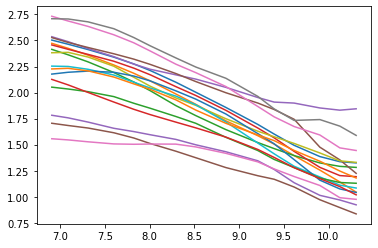

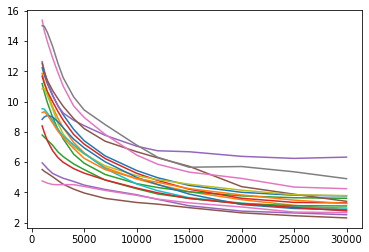

In [4]:
import matplotlib.pyplot as plt
for year in years:
    plt.plot(dictionary_of_res[year]["log_tau"], dictionary_of_res[year]["log_b"])
plt.show()

for year in years:
    plt.plot(dictionary_of_res[year]["tau"], dictionary_of_res[year]["b"])
plt.show()

## Custom Cross-Validation

In [5]:
import plotly.express as px

In [6]:
N_SPLITS = len(years)
from tabulate import tabulate
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from collections import defaultdict
df_res = defaultdict(list)

# Preset year splits
for splitter in range(2, N_SPLITS+1):
    kf = KFold(n_splits=splitter)
    years = np.array(years)

    models = ["Poly5", "Poly2", "Linear", "Exponential Decay", "Power Law"]
    for model_name in models:
        total_train_amse = []
        total_test_amse = []
        average_train_mse = []
        average_test_mse = []
        trained_coef = []
        for split in kf.split(years):
            train_years, test_years = years[split[0]], years[split[1]]
            
            # train to get only the slope
            for year in train_years:
                if model_name == "Exponential Decay" or model_name == "Linear" or "Poly" in model_name:
                    x_s = dictionary_of_res[year]["tau"].tolist()
                else:
                    x_s = dictionary_of_res[year]["log_tau"].tolist()
                
                if model_name == "Linear" or "Poly" in model_name:
                    y_s = dictionary_of_res[year]["b"].tolist()
                    FLAG = False
                else:
                    FLAG = True
                    y_s = dictionary_of_res[year]["log_b"].tolist()
                
                x_s = np.array(x_s)
                y_s = np.array(y_s)
                
                if "Poly" not in model_name:
                    pipe = make_pipeline(LinearRegression())
                elif "Poly5" in model_name:
                    pipe = make_pipeline(PolynomialFeatures(degree=5), LinearRegression())
                elif "Poly2" in model_name:
                    pipe = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

                pipe.fit(x_s.reshape(-1,1), y_s.reshape(-1,1))
                y_s_pred = pipe.predict(x_s.reshape(-1,1))
                if FLAG == True:
                    average_train_mse.append(mean_squared_error(np.exp(y_s.reshape(-1,1)), np.exp(y_s_pred)))
                else:
                    average_train_mse.append(mean_squared_error(y_s.reshape(-1,1), y_s_pred))

                if len(trained_coef) == 0:
                    trained_coef = pipe.steps[-1][1].coef_ 
                else:
                    trained_coef += pipe.steps[-1][1].coef_ 
                    
            trained_coef /= len(train_years)
            # standardscalar is not crowdsourced
            pipe.steps[-1][1].coef_ = trained_coef
            
            # test such that only the slope is used and the offset is learned again
            x_t, y_t = [], []
            for year in test_years:
                if model_name == "Exponential Decay" or model_name == "Linear" or "Poly" in model_name:
                    x_t = dictionary_of_res[year]["tau"].tolist()
                else:
                    x_t = dictionary_of_res[year]["log_tau"].tolist()
                
                if model_name == "Linear" or "Poly" in model_name:
                    y_t = dictionary_of_res[year]["b"].tolist()
                    FLAG = False
                else:
                    y_t = dictionary_of_res[year]["log_b"].tolist()
                    FLAG = True
                
                x_t = np.array(x_t)
                y_t = np.array(y_t)
                
                if "Poly" not in model_name:
                    pipe = make_pipeline(LinearRegression())
                elif "Poly5" in model_name:
                    pipe = make_pipeline(PolynomialFeatures(degree=5), LinearRegression())
                elif "Poly2" in model_name:
                    pipe = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
                    
                pipe.fit(x_t.reshape(-1,1), y_t.reshape(-1,1))
                pipe.steps[-1][1].coef_ = trained_coef
                    
                y_pred = pipe.predict(x_t.reshape(-1,1))
                if FLAG == True:
                    average_test_mse.append(mean_squared_error(np.exp(y_t.reshape(-1,1)), np.exp(y_pred)))
                else:
                    average_test_mse.append(mean_squared_error(y_t.reshape(-1,1), y_pred))
            
            total_test_amse.append(np.average(average_test_mse))
            total_train_amse.append(np.average(average_train_mse))

        df_res[model_name + " train-MSE"].append(np.average(total_train_amse).item())
        df_res[model_name + " train-MSE-err"].append(np.std(total_train_amse).item())
        df_res[model_name + " test-MSE"].append(np.average(total_test_amse).item())
        df_res[model_name + " test-MSE-err"].append(np.std(total_test_amse).item())
    df_res["Training Years"].append(splitter)

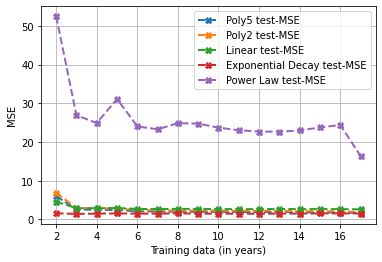

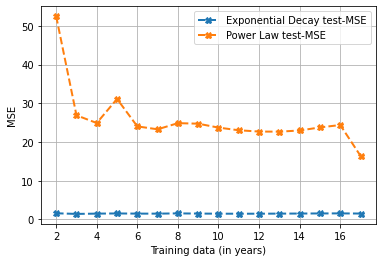

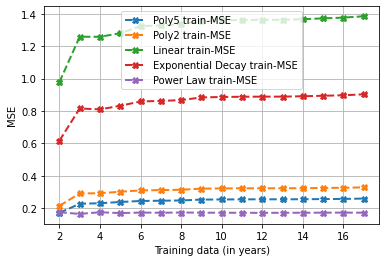

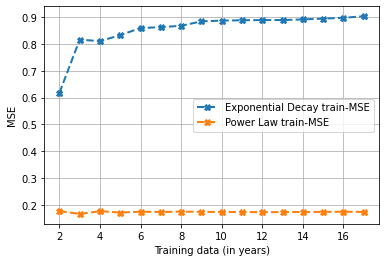

In [7]:
df_pandas = pd.DataFrame(df_res)
new_cols = []
for col in df_pandas.columns:
    if "err" not in col and "test" in col:
        new_cols.append(col)

for col in new_cols:
    plt.plot(df_res['Training Years'], df_res[col], linestyle="--", marker="X", linewidth=2, label=col)
plt.legend()
plt.grid()
plt.xlabel("Training data (in years)")
plt.ylabel("MSE")
plt.show()

new_cols = []
for col in df_pandas.columns:
    if "err" not in col and "test" in col and ("Exp" in col or "Power" in col):
        new_cols.append(col)

for col in new_cols:
    plt.plot(df_res['Training Years'], df_res[col], linestyle="--", marker="X", linewidth=2, label=col)
plt.legend()
plt.grid()
plt.xlabel("Training data (in years)")
plt.ylabel("MSE")
plt.show()

df_pandas = pd.DataFrame(df_res)
new_cols = []
for col in df_pandas.columns:
    if "err" not in col and "test" not in col and "Year" not in col:
        new_cols.append(col)

for col in new_cols:
    plt.plot(df_res['Training Years'], df_res[col], linestyle="--", marker="X", linewidth=2, label=col)
plt.legend()
plt.grid()
plt.xlabel("Training data (in years)")
plt.ylabel("MSE")
plt.show()

new_cols = []
for col in df_pandas.columns:
    if "err" not in col and "test" not in col and ("Exp" in col or "Power" in col) and "Year" not in col:
        new_cols.append(col)

for col in new_cols:
    plt.plot(df_res['Training Years'], df_res[col], linestyle="--", marker="X", linewidth=2, label=col)
plt.legend()
plt.grid()
plt.xlabel("Training data (in years)")
plt.ylabel("MSE")
plt.show()

In [8]:
dictionary_of_res

{2004:       tau  sigma_val          b     log_b    log_tau
 24   1000   0.081771  12.229257  2.503831   6.907755
 25   1200   0.085110  11.749511  2.463812   7.090077
 26   1500   0.089576  11.163742  2.412671   7.313220
 27   2000   0.096336  10.380296  2.339909   7.600902
 28   2500   0.102817   9.726013  2.274804   7.824046
 29   3000   0.109495   9.132818  2.211874   8.006368
 30   4000   0.122551   8.159892  2.099231   8.294050
 31   5000   0.134953   7.410013  2.002832   8.517193
 32   7000   0.156149   6.404121  1.856942   8.853665
 33  10000   0.183772   5.441520  1.694058   9.210340
 34  12000   0.201548   4.961589  1.601726   9.392662
 35  15000   0.224550   4.453356  1.493658   9.615805
 36  20000   0.250167   3.997332  1.385627   9.903488
 37  25000   0.262793   3.805272  1.336388  10.126631
 38  30000   0.265820   3.761945  1.324936  10.308953,
 2005:       tau  sigma_val          b     log_b    log_tau
 24   1000   0.084363  11.853480  2.472621   6.907755
 25   1200   0.

In [9]:
N_SPLITS = len(years)
from tabulate import tabulate
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from collections import defaultdict
df_test_std = defaultdict(list)
df_test_mse = defaultdict(list)
df_train_std = defaultdict(list)
df_train_mse = defaultdict(list)
# df_go = defaultdict(list)

years = np.array(years)
models = ["Poly5", "Poly2", "Linear", "Exponential Decay", "Power Law"]
for model_name in models:
        
        added_test_mse = []
        added_train_mse = []
        added_train_std = []
        added_test_std = []
        
        for year in years:
                
            average_train_mse = []
            average_test_mse = []
            
            if model_name == "Exponential Decay" or model_name == "Linear" or "Poly" in model_name:
                    x_s = dictionary_of_res[year]["tau"].tolist()
            else:
                    x_s = dictionary_of_res[year]["log_tau"].tolist()
                
            if model_name == "Linear" or "Poly" in model_name:
                    y_s = dictionary_of_res[year]["b"].tolist()
                    FLAG = False
            else:
                    FLAG = True
                    y_s = dictionary_of_res[year]["log_b"].tolist()
                
            x_s = np.array(x_s)
            y_s = np.array(y_s)
                
            if "Poly" not in model_name:
                    pipe = make_pipeline(LinearRegression())
            elif "Poly5" in model_name:
                    pipe = make_pipeline(PolynomialFeatures(degree=5), LinearRegression())
            elif "Poly2" in model_name:
                    pipe = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
            
            kf = KFold(n_splits=4)
            for train_index, test_index in kf.split(x_s):
                x_train, y_train = x_s[train_index], y_s[train_index]
                x_test, y_test = x_s[test_index], y_s[test_index]
                
                pipe.fit(x_train.reshape(-1,1), y_train.reshape(-1,1))
                y_train_pred = pipe.predict(x_train.reshape(-1,1))
                y_test_pred = pipe.predict(x_test.reshape(-1,1))
                
                if FLAG == True:
                    average_train_mse.append(mean_squared_error(np.exp(y_train_pred.reshape(-1,1)), np.exp(y_train)))
                else:
                    average_train_mse.append(mean_squared_error(y_train_pred.reshape(-1,1), y_train))
                
                if FLAG == True:
                    average_test_mse.append(mean_squared_error(np.exp(y_test_pred.reshape(-1,1)), np.exp(y_test)))
                else:
                    average_test_mse.append(mean_squared_error(y_test_pred.reshape(-1,1), y_test))
            
            added_train_mse.append(np.average(average_train_mse))
            added_train_std.append(np.std(average_train_mse))
            added_test_mse.append(np.average(average_test_mse))
            added_test_std.append(np.std(average_test_mse))
            
        df_train_mse[model_name].extend(added_train_mse)
        df_train_std[model_name].extend(added_train_std)
        df_test_mse[model_name].extend(added_test_mse)
        df_test_std[model_name].extend(added_test_std)
        

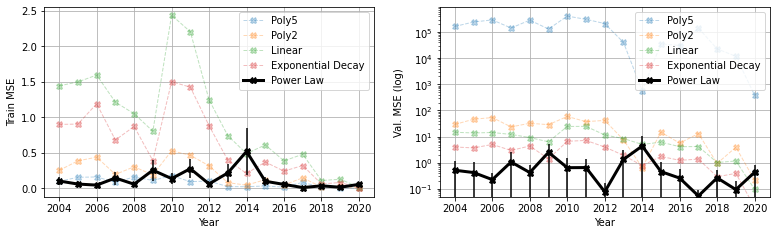

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,3.5))

df_pandas = pd.DataFrame(df_train_mse)
new_cols = []
for col in df_pandas.columns:
        new_cols.append(col)

for col in new_cols:
    if col == "Power Law":
        alpha = 1
        linewidth=3
        color = "black"
        ax1.plot(years, df_train_mse[col], linestyle="-", marker="X", linewidth=linewidth, label=col, alpha=alpha, color=color)
    else:
        alpha = 0.3
        linewidth=1
        ax1.plot(years, df_train_mse[col], linestyle="--", marker="X", linewidth=linewidth, label=col, alpha=alpha)
        
    if col == "Power Law":
        ax1.errorbar(years, df_train_mse[col],
                yerr = df_train_std[col],
                fmt ='.', color="black")
ax1.legend()
ax1.grid()
ax1.set_xlabel("Year")
ax1.set_ylabel("Train MSE")

df_pandas = pd.DataFrame(df_test_mse)
new_cols = []
for col in df_pandas.columns:
    # if "Linear" not in col and "Poly" not in col:
    new_cols.append(col)

for col in new_cols:
    if col == "Power Law":
        alpha = 1
        linewidth=3
        ax2.plot(years, df_test_mse[col], linestyle="-", marker="X", linewidth=linewidth, label=col, alpha=alpha, color="black")

    else:
        alpha = 0.3
        linewidth=1
        ax2.plot(years, df_test_mse[col], linestyle="--", marker="X", linewidth=linewidth, label=col, alpha=alpha)

    if col == "Power Law":
        ax2.errorbar(years, df_test_mse[col],
                yerr = df_test_std[col],
                fmt ='.', color="black")

ax2.legend(loc='upper right')
ax2.grid()
ax2.set_xlabel("Year")
ax2.set_yscale("log")
ax2.set_ylim(0.05,)
ax2.set_ylabel("Val. MSE (log)")
plt.savefig("MAS.png", dpi=600, bbox_inches='tight')
plt.show()